In [14]:
!pip install --upgrade git+http://github.com/renero/dataset
!pip install skrebate
!pip install gplearn

from copy import copy
from dataset import Dataset
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import re
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

  Cloning http://github.com/renero/dataset to /private/var/folders/wv/yvq0c5md1zj9wnt_vwjs6vpc0000gn/T/pip-req-build-2tejjbt3


  Created wheel for dataset: filename=dataset-0.17.1-py3-none-any.whl size=22736 sha256=6964129f08674556911c810e225de46fd40dc3e2082ad27f890a2938385604cb
  Stored in directory: /private/var/folders/wv/yvq0c5md1zj9wnt_vwjs6vpc0000gn/T/pip-ephem-wheel-cache-t92hogk6/wheels/5e/d1/b3/9ef477d13c9620bcfd5984012b4831ba1a2641562d7b0e6b78
Successfully built dataset
  Attempting uninstall: dataset
    Found existing installation: dataset 0.17.1
    Uninstalling dataset-0.17.1:
      Successfully uninstalled dataset-0.17.1


In [222]:
class RiskDataframe():
    
#-----------------------------------------------------------------------------
                        # CLASS INITIALIZATION
#----------------------------------------------------------------------------- 
    def  __init__(self,filename) :
        self.data = pd.read_csv(filename)

#-----------------------------------------------------------------------------
                        # RISK BASED APPROACH
#-----------------------------------------------------------------------------    
    def missing_not_at_random(self, input_vars=[] ):

        for var in input_vars:
            if var not in self.columns:
                print(f"Variable named {var} not in the dataframe. Review the input variable names")
            return
        
        if input_vars==[]: columns = self.columns
        else: columns = input_vars
        missing_value_columns = [column for column in columns if self[column].isnull().values.any()]
        print(f"Missing Not At Random Repport (MNAR) - {', '.join(missing_value_columns) if len(missing_value_columns)>0 else 'No'} variables seem Missing Not at Random, there for we recommend: \n \n Thin File Segment Variables (all others variables free of MNAR issue): {', '.join([column for column in columns if column not in missing_value_columns])} \n \n Full File Segment Variables: {', '.join(columns)}")
        return
        
#-----------------------------------------------------------------------------
                        # DATA CLEANING
#-----------------------------------------------------------------------------

    def start (self,piv,birth_date,target,down_payment,income_status,dates_todays) :
        self._pivot_unique(piv)
        self._clean_target(target)
        self._clean(birth_date)
        self._down(down_payment)
        self._income(income_status)
        self._dayslapsed(dates_todays)
        return self.data
    
    #Remove duplicates using the 'pivot' value established by the user
    def _pivot_unique (self,piv) :
        self.data.drop_duplicates(subset=[piv], keep='last', inplace = True)
        return self.data
    
    #The idea of this analysis is to have a binary bucket 
    def _clean_target (self,target) :
        for i in range(len(self.data.columns)):
            tar = str(self.data.columns[i])
            if tar == target :
                val = np.where(self.data[self.data.columns[i]]>0,1,self.data[self.data.columns[i]])
                self.data[self.data.columns[i]] = val
        return self.data
    
    # Getting the agre from the birth date in the dataFrame and cleainig empty spaces
    def _clean(self,birth_date) :

        data = Dataset.from_dataframe(self.data)
        numerical_features = data.numerical_features
        categorical_features = data.categorical_features
        
        # clean numerical values
        for i in range(len(self.data.columns)):
            empty = self.data[self.data.columns[i]].isna().any()
            if empty == True and self.data.columns[i] in numerical_features:
                val = self.data[self.data.columns[i]].fillna(self.data[self.data.columns[i]].mean())
                self.data[self.data.columns[i]] = val
        
        # clean categorical values
            # fill empty
        for i in range(len(self.data.columns)):
            empty = self.data[self.data.columns[i]].isna().any()
            if empty == True and self.data.columns[i] in categorical_features:
                val = self.data[self.data.columns[i]].fillna('UNKNOWN')
                self.data[self.data.columns[i]] = val
            
            # upper case
        for i in range(len(self.data.columns)):
            if self.data.columns[i] in categorical_features:
                val = self.data[self.data.columns[i]].str.upper()
                self.data[self.data.columns[i]] = val
        
        # if birth date, return age
        def age(born):
            while True:
                try:
                    born = datetime.datetime.strptime(born, "%Y-%m-%d").date()
                    today = date.today()
                    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
                except ValueError:
                    return 'UNKNOWN'
        for i in range(len(self.data.columns)):
            dateb = str(self.data.columns[i])
            if self.data.columns[i] in categorical_features and dateb == birth_date :
                val = self.data[self.data.columns[i]].apply(age)
                self.data[self.data.columns[i]] = val

        return self.data

    # The down Payment has to mean something in order to be useful in the Model. We get the % in each value. Also we separate between individuals and corporate
    
    def _down(self,down_payment) :
        def pay(payment) :
            y = re.findall('\d+', payment)
            if len(y) > 0 :
                result = int(y[0])/100
            else:
                result = 0
            return result
        
        def ty(types) :
            if 'EMPLOYED' in types :
                return 'EMPLOYED'
            else:
                return 'CORPORATE'
        
        self.data["DOWN_PAYMENT"] = None
        self.data["TYPE"] = None
        val = self.data[down_payment].apply(pay)
        self.data["DOWN_PAYMENT"] = val
        
        val = self.data[down_payment].apply(ty)
        self.data["TYPE"] = val
        self.data.drop(columns = [down_payment], inplace = True)
        
        return self.data
    
    # There are too many jobs, we can isolate between those who get some income and unemployed guys
    def _income (self,income_status) :
        def income(incomes) :
            if 'UNEMPLOYED' in incomes :
                return 'UNEMPLOYED'
            else:
                return 'ACTIVE' 
       
        val = self.data[income_status].apply(income)
        self.data[income_status] = val
    
    # Dates are not useful for the model, we need numerical values.
    
    def _dayslapsed (self,dates_todays):
        def daily(dai) :
            change = datetime.datetime.strptime(dai, "%Y-%m-%d").date()
            today = date.today()
            delta = today - change
            return delta.days
        
        for i in range(len(dates_todays)):
            self.data[dates_todays[i]+'_DAYS_LAPSED'] = None
            val = self.data[dates_todays[i]].apply(daily)
            self.data[dates_todays[i]+'_DAYS_LAPSED'] = val
            self.data.drop(columns = [dates_todays[i]], inplace = True)
            
#-----------------------------------------------------------------------------
                        # DATA ANALYSIS
#-----------------------------------------------------------------------------
        #-----------------------------------------------------------------------------
                        # CATEGORICAL VARIABLES ANALYSIS
        #-----------------------------------------------------------------------------
    
    def set_train_cat (self,target_value,seg_data):
        
        df_random_sample, _ = train_test_split(self.data, test_size=0.90)
        
        
        def get_specific_columns(df_random_sample, data_types, to_ignore = list(), ignore_target = False):
            columns = df_random_sample.select_dtypes(include=data_types).columns
            if ignore_target:
                columns = filter(lambda x: x not in to_ignore, list(columns))
            return list(columns)
        
        all_numeric_variables = get_specific_columns(df_random_sample, ["float64", "int64"], [target_value], ignore_target = True)
        
        splitter = train_test_split
        df_train, df_test = splitter(df_random_sample, test_size = 0.2, random_state = 42)
        
        X_train = df_train[all_numeric_variables]
        y_train = df_train[target_value]
        
        X_test = df_test[all_numeric_variables]
        y_test = df_test[target_value]
        
        method = LogisticRegression(random_state=0)
        fitted_full_model = method.fit(X_train, y_train)
        y_pred = fitted_full_model.predict(X_test)
        
        # Result accuracy all model
        full_model = accuracy_score(y_test, y_pred)
        result_full_model_etal =  ["The total accuracy using all variable and Logistic regression is: " + str(full_model)]
        
        conclusion_model = []
        
        for seg in range(len(seg_data)):
            
            max_value_seg = self.data[seg_data[seg]].value_counts().idxmax()
            
            # set dataframes of train and test
            
            df_train_seg1 = df_train[df_random_sample[seg_data[seg]] == max_value_seg]
            df_train_seg2 = df_train[df_random_sample[seg_data[seg]] != max_value_seg]
            df_test_seg1 = df_test[df_random_sample[seg_data[seg]] == max_value_seg]
            df_test_seg2 = df_test[df_random_sample[seg_data[seg]] != max_value_seg]
            
            #getting results seg 1 vs seg 1
           
            X_train_seg1 = df_train_seg1[all_numeric_variables]
            y_train_seg1 = df_train_seg1[target_value]
            X_test_seg1 = df_test_seg1[all_numeric_variables]
            y_test_seg1 = df_test_seg1[target_value]
            
            fitted_model_seg1 = method.fit(X_train_seg1, y_train_seg1)
            
            def GINI(y_test, y_pred_probadbility):
                from sklearn.metrics import roc_curve, auc
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_probadbility)
                roc_auc = auc(fpr, tpr)
                GINI = (2 * roc_auc) - 1
                return(GINI)
            
            y_pred_seg1_proba = fitted_model_seg1.predict_proba(X_test_seg1)[:,1]
            y_pred_seg1_fullmodel_proba = fitted_full_model.predict_proba(X_test_seg1)[:,1]
            
            
            result_full_model_etal.append("Using: " + seg_data[seg] + " GINI Full Model Seg1: "+ str(GINI(y_test_seg1, y_pred_seg1_proba)*100)+"%")
            result_full_model_etal.append("Using: " + seg_data[seg] + " GINI Segmented Model Seg1: "+ str(GINI(y_test_seg1, y_pred_seg1_fullmodel_proba)*100)+"%")
            
            #getting results seg 2 vs seg 2

            
            X_train_seg2 = df_train_seg2[all_numeric_variables]
            y_train_seg2 = df_train_seg2[target_value]
            X_test_seg2 = df_test_seg2[all_numeric_variables]
            y_test_seg2 = df_test_seg2[target_value]
            fitted_model_seg2 = method.fit(X_train_seg2, y_train_seg2)
            y_pred_seg2 = fitted_model_seg2.predict(X_test_seg2)
            y_pred_seg2_fullmodel = fitted_full_model.predict(X_test_seg2)
            
            y_pred_seg2_proba = fitted_model_seg1.predict_proba(X_test_seg2)[:,1]
            y_pred_seg2_fullmodel_proba = fitted_full_model.predict_proba(X_test_seg2)[:,1]
            
            result_full_model_etal.append("Using: " + seg_data[seg] +" GINI Full Model Seg2: " + str(GINI(y_test_seg2, y_pred_seg2_proba)*100) +"%")
            result_full_model_etal.append("Using: " + seg_data[seg] +" GINI Segmented Model Seg2:" + str(GINI(y_test_seg2, y_pred_seg2_fullmodel_proba)*100)+"%") 
                    
            if GINI(y_test_seg1, y_pred_seg1_proba)*100 < 20 or GINI(y_test_seg2, y_pred_seg2_proba)*100 < 20:
                
                conclusion_model.append("After analysis, we did not find a good split using: " + seg_data[seg])
            else:
                conclusion_model.append("After analysis, we find a good split using: " + seg_data[seg] + " set at: " + str(max_value_seg))
        
        return result_full_model_etal, conclusion_model
    
        #-----------------------------------------------------------------------------
                        # ENCODING
        #-----------------------------------------------------------------------------
    
    def encod (self, seg_data_cat):
        data = Dataset.from_dataframe(self.data)
        for seg in range(len(seg_data_cat)):
            data.onehot_encode(seg_data_cat[seg])
            data.drop_columns(seg_data_cat[seg])
        
        self.data = data.features
        
        return self.data
    
        #-----------------------------------------------------------------------------
                        # NUMERICAL VARIABLES ANALYSIS
        #-----------------------------------------------------------------------------
    
    def set_train_num (self,seg_data_cat,target_value,seg_data_num): 
        
        # Lets get rid of Unknown values so that we can have means in each column
        for dro in range(len(seg_data_num)):
            self.data.drop(self.data.index[self.data[seg_data_num[dro]] == 'UNKNOWN'], inplace = True)
        
        def get_specific_columns(df_random_sample, data_types, to_ignore = list(), ignore_target = False):
            columns = df_random_sample.select_dtypes(include=data_types).columns
            if ignore_target:
                columns = filter(lambda x: x not in to_ignore, list(columns))
            return list(columns)
        

        df_random_sample, _ = train_test_split(self.data, test_size=0.90)
        all_numeric_variables = get_specific_columns(df_random_sample, ["float64", "int64"], [target_value], ignore_target = True)
        
        splitter = train_test_split
        df_train, df_test = splitter(df_random_sample, test_size = 0.2, random_state = 42)
        
        result_full_model_etal = []
        
        X_train = df_train[all_numeric_variables]
        y_train = df_train[target_value]
        
        X_test = df_test[all_numeric_variables]
        y_test = df_test[target_value]
        
        method = LogisticRegression(random_state=0)
        fitted_full_model = method.fit(X_train, y_train)
        y_pred = fitted_full_model.predict(X_test)
        
        full_model = accuracy_score(y_test, y_pred)
        result_full_model_etal =  ["The total accuracy using all variable and Logistic regression is: " + str(full_model)]
        
        conclusion_model = []
       
        for seg in range(len(seg_data_num)):
            
            mean_value_seg = self.data[seg_data_num[seg]].mean()
            
            # set dataframes of train and test
            
            df_train_seg1 = df_train[df_random_sample[seg_data_num[seg]] >= mean_value_seg]
            df_train_seg2 = df_train[df_random_sample[seg_data_num[seg]] < mean_value_seg]
            df_test_seg1 = df_test[df_random_sample[seg_data_num[seg]] >=  mean_value_seg]
            df_test_seg2 = df_test[df_random_sample[seg_data_num[seg]] < mean_value_seg]
            
            #getting results seg 1 vs seg 1
           
            X_train_seg1 = df_train_seg1[all_numeric_variables]
            y_train_seg1 = df_train_seg1[target_value]
            X_test_seg1 = df_test_seg1[all_numeric_variables]
            y_test_seg1 = df_test_seg1[target_value]
            
            fitted_model_seg1 = method.fit(X_train_seg1, y_train_seg1)
            
            def GINI(y_test, y_pred_probadbility):
                from sklearn.metrics import roc_curve, auc
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_probadbility)
                roc_auc = auc(fpr, tpr)
                GINI = (2 * roc_auc) - 1
                return(GINI)
            
            y_pred_seg1_proba = fitted_model_seg1.predict_proba(X_test_seg1)[:,1]
            y_pred_seg1_fullmodel_proba = fitted_full_model.predict_proba(X_test_seg1)[:,1]
            
            
            result_full_model_etal.append("Using: " + seg_data_num[seg] + " GINI Full Model Seg1: "+ str(GINI(y_test_seg1, y_pred_seg1_proba)*100)+"%")
            result_full_model_etal.append("Using: " + seg_data_num[seg] + " GINI Segmented Model Seg1: "+ str(GINI(y_test_seg1, y_pred_seg1_fullmodel_proba)*100)+"%")
            
            #getting results seg 2 vs seg 2

            
            X_train_seg2 = df_train_seg2[all_numeric_variables]
            y_train_seg2 = df_train_seg2[target_value]
            X_test_seg2 = df_test_seg2[all_numeric_variables]
            y_test_seg2 = df_test_seg2[target_value]
            fitted_model_seg2 = method.fit(X_train_seg2, y_train_seg2)
            y_pred_seg2 = fitted_model_seg2.predict(X_test_seg2)
            y_pred_seg2_fullmodel = fitted_full_model.predict(X_test_seg2)
            
            y_pred_seg2_proba = fitted_model_seg1.predict_proba(X_test_seg2)[:,1]
            y_pred_seg2_fullmodel_proba = fitted_full_model.predict_proba(X_test_seg2)[:,1]
            
            result_full_model_etal.append("Using: " + seg_data_num[seg] +" GINI Full Model Seg2: " + str(GINI(y_test_seg2, y_pred_seg2_proba)*100) +"%")
            result_full_model_etal.append("Using: " + seg_data_num[seg] +" GINI Segmented Model Seg2: " + str(GINI(y_test_seg2, y_pred_seg2_fullmodel_proba)*100)+"%") 
            
            if GINI(y_test_seg1, y_pred_seg1_proba)*100 < 20 or GINI(y_test_seg2, y_pred_seg2_proba)*100 < 20:
                conclusion_model.append("After analysis, we did not find a good split using: " + seg_data_num[seg])
            else:
                conclusion_model.append("After analysis, we find a good split using: " + seg_data_num[seg] + " set at: " + str(mean_value_seg))
        
                
        return result_full_model_etal, conclusion_model

#-----------------------------------------------------------------------------
                        # DATA VISUALIZATION
#-----------------------------------------------------------------------------

    def plot_risk (self,variable):
        plt.hist(self.data[variable], color='g', label='Ideal')
        print(self.data.describe())
        

In [223]:
file = RiskDataframe('AUTO_LOANS_DATA.csv')

In [224]:
pivot_value = 'ACCOUNT_NUMBER'
target_value = 'BUCKET'
down_payment = 'PROGRAM_NAME'
income_status = 'PROFESSION'
birth_date = 'BIRTH_DATE'
dates_todays = ['REPORTING_DATE','LOAN_OPEN_DATE','EXPECTED_CLOSE_DATE','CUSTOMER_OPEN_DATE']

file.start(pivot_value,birth_date,target_value, down_payment,income_status,dates_todays)

,ACCOUNT_NUMBER,CUSTOMER_ID,ORIGINAL_BOOKED_AMOUNT,OUTSTANDING,BUCKET,SEX,BIRTH_DATE,PROFESSION,CAR_TYPE,DOWN_PAYMENT,TYPE,REPORTING_DATE_DAYS_LAPSED,LOAN_OPEN_DATE_DAYS_LAPSED,EXPECTED_CLOSE_DATE_DAYS_LAPSED,CUSTOMER_OPEN_DATE_DAYS_LAPSED
143,144,144,140500.0,0.00,0,M,39,ACTIVE,UNKNOWN,0.5,EMPLOYED,2044,2272,1555,3036
247,248,248,70000.0,0.00,1,F,37,ACTIVE,UNKNOWN,0.5,EMPLOYED,2044,3568,1737,3581
308,309,307,65500.0,0.00,0,M,44,ACTIVE,UNKNOWN,0.5,EMPLOYED,2044,3274,1463,3280
350,351,349,44500.0,0.00,1,M,40,ACTIVE,UNKNOWN,0.5,EMPLOYED,2044,2617,1160,2622
465,466,12,93000.0,0.00,0,UNKNOWN,UNKNOWN,ACTIVE,UNKNOWN,0.0,CORPORATE,2044,3478,2047,7611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900855,36547,35528,90000.0,78956.52,0,M,27,ACTIVE,GELORY,0.5,EMPLOYED,738,1074,-728,1085
900856,39597,38396,92500.0,92826.06,0,F,44,ACTIVE,GELORY,0.5,EMPLOYED,738,739,-1094,752
900857,38016,36905,140250.0,114919.47,0,M,41,ACTIVE,NISSAN,0.0,CORPORATE,738,899,186,950
900858,38899,37739,105000.0,101714.25,0,M,35,ACTIVE,DFSK,0.0,CORPORATE,738,802,-1002,831


In [225]:
seg_data_cat =['SEX','PROFESSION','CAR_TYPE','TYPE'] 

In [226]:
file.set_train_cat(target_value,seg_data_cat)

(['The total accuracy using all variable and Logistic regression is: 0.9027777777777778',
  'Using: SEX GINI Full Model Seg1: 27.55821078431373%',
  'Using: SEX GINI Segmented Model Seg1: 27.55821078431373%',
  'Using: SEX GINI Full Model Seg2: 9.700644183402796%',
  'Using: SEX GINI Segmented Model Seg2:9.700644183402796%',
  'Using: PROFESSION GINI Full Model Seg1: 20.002204302062854%',
  'Using: PROFESSION GINI Segmented Model Seg1: 20.002204302062854%',
  'Using: PROFESSION GINI Full Model Seg2: nan%',
  'Using: PROFESSION GINI Segmented Model Seg2:nan%',
  'Using: CAR_TYPE GINI Full Model Seg1: 20.236686390532554%',
  'Using: CAR_TYPE GINI Segmented Model Seg1: 20.236686390532554%',
  'Using: CAR_TYPE GINI Full Model Seg2: 18.942307692307715%',
  'Using: CAR_TYPE GINI Segmented Model Seg2:18.942307692307715%',
  'Using: TYPE GINI Full Model Seg1: 22.65356265356264%',
  'Using: TYPE GINI Segmented Model Seg1: 22.65356265356264%',
  'Using: TYPE GINI Full Model Seg2: -39.39393939393

In [227]:
seg_data_num = ['ORIGINAL_BOOKED_AMOUNT','OUTSTANDING','BIRTH_DATE','DOWN_PAYMENT','REPORTING_DATE_DAYS_LAPSED','LOAN_OPEN_DATE_DAYS_LAPSED','EXPECTED_CLOSE_DATE_DAYS_LAPSED','CUSTOMER_OPEN_DATE_DAYS_LAPSED']

In [228]:
file.encod(seg_data_cat)

,ACCOUNT_NUMBER,BIRTH_DATE,BUCKET,CAR_TYPE_AUDI,CAR_TYPE_BAIC,CAR_TYPE_BMW,CAR_TYPE_BRILLIANCE,CAR_TYPE_BYD,CAR_TYPE_CARRY,CAR_TYPE_CHANA,...,ORIGINAL_BOOKED_AMOUNT,OUTSTANDING,PROFESSION_ACTIVE,PROFESSION_UNEMPLOYED,REPORTING_DATE_DAYS_LAPSED,SEX_F,SEX_M,SEX_UNKNOWN,TYPE_CORPORATE,TYPE_EMPLOYED
143,144.0,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,140500.0,0.00,1.0,0.0,2044.0,0.0,1.0,0.0,0.0,1.0
247,248.0,37,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70000.0,0.00,1.0,0.0,2044.0,1.0,0.0,0.0,0.0,1.0
308,309.0,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65500.0,0.00,1.0,0.0,2044.0,0.0,1.0,0.0,0.0,1.0
350,351.0,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44500.0,0.00,1.0,0.0,2044.0,0.0,1.0,0.0,0.0,1.0
465,466.0,UNKNOWN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,93000.0,0.00,1.0,0.0,2044.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900855,36547.0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90000.0,78956.52,1.0,0.0,738.0,0.0,1.0,0.0,0.0,1.0
900856,39597.0,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,92500.0,92826.06,1.0,0.0,738.0,1.0,0.0,0.0,0.0,1.0
900857,38016.0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,140250.0,114919.47,1.0,0.0,738.0,0.0,1.0,0.0,1.0,0.0
900858,38899.0,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105000.0,101714.25,1.0,0.0,738.0,0.0,1.0,0.0,1.0,0.0


In [229]:
file.set_train_num(seg_data_cat,target_value,seg_data_num)

(['The total accuracy using all variable and Logistic regression is: 0.8831003811944091',
  'Using: ORIGINAL_BOOKED_AMOUNT GINI Full Model Seg1: 36.84004309922617%',
  'Using: ORIGINAL_BOOKED_AMOUNT GINI Segmented Model Seg1: 36.84004309922617%',
  'Using: ORIGINAL_BOOKED_AMOUNT GINI Full Model Seg2: 28.980919722148933%',
  'Using: ORIGINAL_BOOKED_AMOUNT GINI Segmented Model Seg2: 28.980919722148933%',
  'Using: OUTSTANDING GINI Full Model Seg1: 31.583011583011576%',
  'Using: OUTSTANDING GINI Segmented Model Seg1: 31.583011583011576%',
  'Using: OUTSTANDING GINI Full Model Seg2: 30.070588235294117%',
  'Using: OUTSTANDING GINI Segmented Model Seg2: 30.070588235294117%',
  'Using: BIRTH_DATE GINI Full Model Seg1: 32.332089552238806%',
  'Using: BIRTH_DATE GINI Segmented Model Seg1: 32.332089552238806%',
  'Using: BIRTH_DATE GINI Full Model Seg2: 29.175925925925927%',
  'Using: BIRTH_DATE GINI Segmented Model Seg2: 29.175925925925927%',
  'Using: DOWN_PAYMENT GINI Full Model Seg1: 26.72

       ACCOUNT_NUMBER        BUCKET  CAR_TYPE_AUDI  CAR_TYPE_BAIC  \
count    39319.000000  39319.000000   39319.000000   39319.000000   
mean     19806.861136      0.119306       0.000254       0.006028   
std      11426.164302      0.324153       0.015946       0.077404   
min          1.000000      0.000000       0.000000       0.000000   
25%       9917.500000      0.000000       0.000000       0.000000   
50%      19818.000000      0.000000       0.000000       0.000000   
75%      29681.500000      0.000000       0.000000       0.000000   
max      39597.000000      1.000000       1.000000       1.000000   

       CAR_TYPE_BMW  CAR_TYPE_BRILLIANCE  CAR_TYPE_BYD  CAR_TYPE_CARRY  \
count  39319.000000         39319.000000  39319.000000    39319.000000   
mean       0.003433             0.006638      0.037590        0.000229   
std        0.058496             0.081204      0.190205        0.015128   
min        0.000000             0.000000      0.000000        0.000000   
25%     

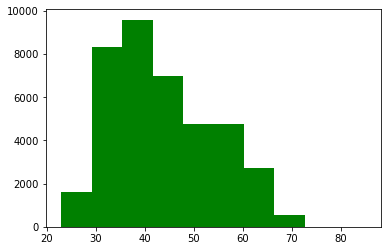

In [230]:
file.plot_risk("BIRTH_DATE")